In [1]:
import numpy as np
import xarray as xr
import rioxarray as rxr

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs

import geopandas as gpd
from rasterio.features import rasterize

import xscen as xs
from xscen.config import CONFIG
import figanos.matplotlib as fg

from plot_settings import PROJECTION, DPI, make_standardizer, save_plot
import os
fig_path = CONFIG["paths"]["figures"]

fg.utils.set_mpl_style('ouranos')

# Load configuration
xs.load_config(
    "../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True
)

2025-08-29 14:26:33 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-08-29 14:26:33 INFO     xscen.config    Updated the config with ../config_obs.yml.


In [2]:
# Load topography path from config
topo_path = CONFIG["paths"]["topography"]

# Load the ETOPO GeoTIFF and squeeze band dimension if it exists
topo_da = rxr.open_rasterio(topo_path).squeeze()

# Reproject to WGS84 (lat/lon) if needed
if topo_da.rio.crs != "EPSG:4326":
    topo_da = topo_da.rio.reproject("EPSG:4326")

# Rename coordinates to 'lat' and 'lon'
topo_da = topo_da.rename({"x": "lon", "y": "lat"})

# Drop unused variables if present
topo_da = topo_da.drop_vars(["band", "spatial_ref"], errors="ignore")

# Convert DataArray to Dataset for easier handling
topo_ds = topo_da.to_dataset(name="topography")

# Load region shapefile
region_shp = gpd.read_file("../" + CONFIG["regional_mean"]["region"]["shape"])

# Coarsen the topography to reduce resolution
topo_coarse = topo_ds.coarsen(lat=2, lon=2, boundary="trim").mean()

# Subset topography using the region shape
topo_subset = xs.spatial.subset(
    topo_coarse,
    method="shape",
    shape=region_shp,
    tile_buffer=0,
)

topo_subset.topography.attrs.update({
    "units": "m",
    "long_name": "Elevation",
    "description": "Topography"
})

In [3]:
lake_path = CONFIG["paths"]["lakes"]

# Step 1: Load the HydroLAKES polygon shapefile
lake_gdf = gpd.read_file(lake_path)

# Remove small lakes
lake_gdf = lake_gdf[lake_gdf["Lake_area"] >= 100]

# Keep only lakes that intersect the region
lake_gdf = gpd.overlay(lake_gdf, region_shp, how="intersection")

# Step 2: Reproject to lat/lon (WGS84) to match topo_subset
lake_gdf = lake_gdf.to_crs("EPSG:4326")

# Step 3: Get spatial info from topography (already subsetted and coarsened)
lat = topo_subset.lat
lon = topo_subset.lon
transform = topo_subset.rio.transform()
out_shape = topo_subset.rio.shape

# Step 4: Rasterize the lake polygons
lake_raster = rasterize(
    [(geom, 1) for geom in lake_gdf.geometry],
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

# Step 5: Convert to xarray DataArray
lake_mask = xr.DataArray(
    lake_raster,
    coords={"lat": lat, "lon": lon},
    dims=("lat", "lon"),
    name="lake_mask"
)

# Step 6: Convert to Dataset and add metadata to match topo_ds
lake_ds = lake_mask.to_dataset()

In [4]:
# Get the base colormap
base_cmap = plt.get_cmap("Blues")

# Create a modified version that emphasizes dark tones at the start
colors = base_cmap(np.linspace(0.0, 1.0, 256))
colors[:64] *= 0.6  # darken the lowest quarter (values from 0 to ~0.25)

custom_blues = LinearSegmentedColormap.from_list("custom_blues", ["lightblue", "darkblue"])

In [5]:
# Small helper method to more easily highlight parts of the topography and hydrography plots
# 1. Go to Google maps
# 2. Choose first point, copy and paste coordinates
# 3. Choose second point, copy and paste coordinates
# 4. Run the method and copy paste the new line of code into the list of boxes
def print_bounding_box(lat1, lon1, lat2, lon2):
    minx = round(min(lon1, lon2), 2)
    maxx = round(max(lon1, lon2), 2)
    miny = round(min(lat1, lat2), 2)
    maxy = round(max(lat1, lat2), 2)

    print(f"box({minx}, {miny}, {maxx}, {maxy}),")


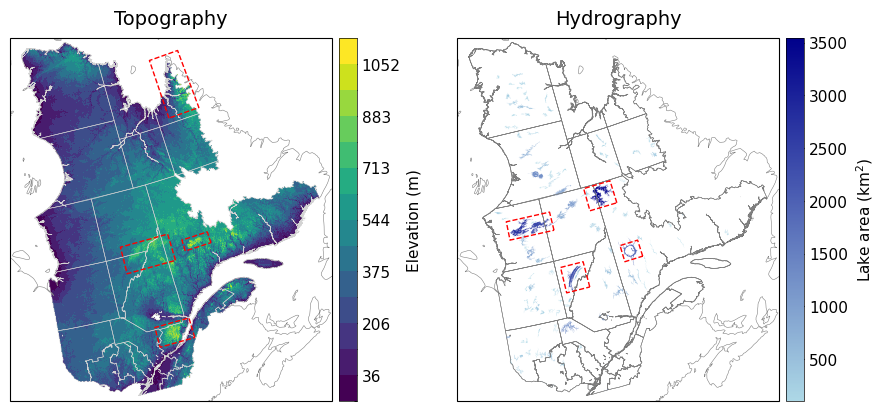

In [6]:


# Reproject vector data to match the axis projection
lake_proj = lake_gdf.to_crs(PROJECTION.proj4_init)
region_proj = region_shp.to_crs(PROJECTION.proj4_init)

# Create figure and two side-by-side subplots
fig, (ax_topo, ax_hydro) = plt.subplots(
    ncols=2,
    figsize=(9, 4),
    subplot_kw={'projection': PROJECTION},
    constrained_layout=True
)

# === LEFT: Topography ===
topo_subset.topography.plot.pcolormesh(
    ax=ax_topo,
    transform=ccrs.PlateCarree(),  # topography is still in lat/lon
    cmap="viridis",
    levels=15,
    vmin=topo_subset.topography.min(),
    vmax=topo_subset.topography.max(),
    cbar_kwargs={"pad": 0.02, "label": "Elevation (m)"},
    zorder=-3
)

ax_topo.set_title("Topography")
standardize_topo = make_standardizer(region_kw={"edgecolor": "lightgray"})
standardize_topo(ax_topo)


# Show visible frame around ax_topo
ax_topo.spines['geo'].set_visible(True)
ax_topo.spines['geo'].set_linewidth(0.8)

# === RIGHT: Lake Coverage ===
lake_proj.plot(
    ax=ax_hydro,
    column="Lake_area",
    cmap=custom_blues,
    legend=True,
    legend_kwds={
        "orientation": "vertical",
        "pad": 0.02,
        "label": "Lake area ($\\mathrm{km}^2$)"
    }
)
region_proj.plot(
    ax=ax_hydro,
    edgecolor="gray",
    facecolor="none",
    linewidth=0.3
)
ax_hydro.set_title("Hydrography")
standardize_hydro = make_standardizer()
standardize_hydro(ax_hydro)

# Show visible frame around ax_hydro
ax_hydro.spines['geo'].set_visible(True)
ax_hydro.spines['geo'].set_linewidth(0.8)

from shapely.geometry import box

def add_boxes(ax, boxes):
    ax.add_geometries(
        boxes,
        crs=ccrs.PlateCarree(),
        facecolor='none',
        edgecolor='red',
        linewidth=1,
        linestyle='--'
    )

boxes_topo = [ # minx, miny, maxx, maxy
    box(-63.537167, 57.713163, -66.359246, 60.575359),
    box(-73.37, 51.04, -69.44, 52.39),
    box(-68.49, 51.34, -66.37, 51.9),
    box(-72.36, 47.09, -69.72, 48.11),
]

add_boxes(ax_topo, boxes_topo)

boxes_hydro = [ # minx, miny, maxx, maxy
    box(-70.87, 53.83, -68.56, 54.95),
    box(-77.81, 53.36, -74.13, 54.27),
    box(-69.33, 50.95, -67.87, 51.78),
    box(-74.33, 50.22, -72.49, 51.51),
]

add_boxes(ax_hydro, boxes_hydro)

save_plot(fig, processing_level="extra", horizon="NA", freq="NA", file_name="topography_hydrography")

plt.show()


Mountain ranges and large (>100km2) lakes within Quebec. Areas of interest are indicated in red. For topography (from North to South), Monts Torngat, Monts Otish, Monts Groulx, Massif du Lac Jacques-Cartier. For hydrography (from North to South), Lac Perroche, réservoir de La Grande Rivière, Lac Manicouagan, Lac Mistassini